# Demonstration of Custom LPF File Creation

Overview of the functionality of the Python LPF creation utilities. These can be used to create arbitrarily complex LPF programs that may be outside the scope of Iris or that need to break some of Iris' assumptions. For example, the LPF timestep can be decreased in order to create highly dynamic LPFs, and complex arbitrary input waveforms can be created in a more straight-forward manner.

To demonstrate this, we will produce an exmaple LPF which encodes PWM input waveforms spanning a very wide array of periods, from 100ms to 60min.

In [1]:
%matplotlib inline
import numpy as np
import os, sys, random

paths = {}
paths['dir'] = os.path.abspath(os.path.dirname(os.path.realpath('__file__')))
paths['TestFile'] = os.path.join(paths['dir'],'program.lpf')

sys.path.append(paths['dir'])
import LPFParser as lpfp
import LPFEncoder as lpfe

### Define device parameters

Define the (required) device parameters, which will define the header information in the LPF, and which must match the LPF data.
```
deviceParams [Required]: dict containing all device parameters
		'channelNum': (int) number of channels in the device
                      (TOTAL channels, ie wells*channels per well)
        'numSteps': (int) number of timesteps
        'timeStep': (int) time step resolution for LPF file (ms)
```

In [2]:
# Define the basic parameters of our device
#############
rowNum = 4
colNum = 6 # e.g. 24-well plate
ledsPerWell = 2
totalTime = 60 # min -- not a normal experiment length (e.g. 480 or 720min), but shorter to make code faster
timeStep = 50 # ms -- want a 50ms timestep because the fastest PWM input period is 100ms

# Define time (when inputs change, in ms) and intensity (in GS units) matrices
#############
# Note: don't forget to add timeStep to the total time; total time must be in ms!
times = np.arange(0, totalTime*60*1000 + timeStep, timeStep)
# Note: the dtype of the intensity array is important for writing correct LPF files!
gsints = np.zeros((len(times), rowNum, colNum, ledsPerWell), dtype=np.int16)
## Structure of this matrix: [time][row][col][channel]
## All intensities must be in the range [0,4095]

# Device params:
dp = {}
dp['channelNum'] = rowNum * colNum * ledsPerWell # TOTAL number of channels
dp['numSteps'] = len(times)
dp['timeStep'] = timeStep

### Apply inputs to GS matrix (Construct Inputs)

We'll define the PWM parameters, define any desired randomization, specify control wells, and apply all these inputs to the GS matrix (`gsints` in this example). 

**Note** that in this exmaple device, the two LEDs are red (top) and green (bottom), corresponding to channel indices 0 and 1, respectively.

***Important:*** If randomization is used, be sure to print or save this randomization matrix -- it is NOT recoverable from the LPF file.

In [3]:
dc = 0.5 # PWM duty-cycle (50%)
# Periods from 100ms to 60min, all in ms
periods = np.concatenate((np.array([50*np.power(2,i) for i in range(1,5)]), 
                          np.logspace(np.log10(1600), np.log10(60*60*1000), 21-4)))

# Define PWM high and low values for each channel
high = {'G': 1000, 'R': 4095}
low = {'G': 0, 'R': 0}

# Define control wells (monochromatic, constant)
# format:
#  wellIndex : (red_int, green_int)
controls = {21: (4095,0), 
            22: (0, 4095), 
            23:(0,0)}

# Randomization
rm = range(rowNum*colNum)
## If randomization is desired, shuffle this matrix:
random.shuffle(rm)
## IMPORTANT: 
## If randomization is used, be sure to print or otherwise save this randomization matrix -- 
## it is NOT recoverable from the LPF file!!
print "Randomization matrix:\n%s"%repr(rm)

# Update gsints matrix:
## Controls:
for i,(r,g) in controls.iteritems():
    row, col = lpfe.wellNumToRC(rm[i]) ## Note the use of the randomizaiton matrix here
    # Write red & green (top & bottom; indices 0 & 1) intensities, which are constant (equal at all times)
    gsints[:,row,col,0] = r
    gsints[:,row,col,1] = g
## PWM Input wells:
for i in range(21): # all the remaining wells
    row, col = lpfe.wellNumToRC(rm[i]) # again the incorporation of the randomization matrix
    p = periods[i]
    for ti,t in enumerate(times): # iterate through all timesteps
        if (t%p)/float(p) < dc: # fraction of the period < dc * period --> green LED high, red low
            r = low['R']
            g = high['G']
        else: # green low, red high
            r = high['R']
            g = low['G']
        gsints[ti,row,col,0] = r
        gsints[ti,row,col,1] = g

# Turn all wells & channels off on finish:
gsints[-1,:,:,:] = 0

Randomization matrix:
[20, 15, 8, 13, 18, 2, 0, 10, 21, 6, 14, 16, 5, 12, 7, 19, 1, 23, 9, 3, 11, 22, 17, 4]
Control: 21 (22,r=3,c=4) -- G=0, R=4095
Control: 22 (17,r=2,c=5) -- G=4095, R=0
Control: 23 (4,r=0,c=4) -- G=0, R=0
0	Writing well 20 (r=3,c=2), period=100 ms
1	Writing well 15 (r=2,c=3), period=200 ms
2	Writing well 8 (r=1,c=2), period=400 ms
3	Writing well 13 (r=2,c=1), period=800 ms
4	Writing well 18 (r=3,c=0), period=1599 ms
5	Writing well 2 (r=0,c=2), period=2591 ms
6	Writing well 0 (r=0,c=0), period=4198 ms
7	Writing well 10 (r=1,c=4), period=6802 ms
8	Writing well 21 (r=3,c=3), period=11019 ms
9	Writing well 6 (r=1,c=0), period=17851 ms
10	Writing well 14 (r=2,c=2), period=28919 ms
11	Writing well 16 (r=2,c=4), period=46848 ms
12	Writing well 5 (r=0,c=5), period=75894 ms
13	Writing well 12 (r=2,c=0), period=122948 ms
14	Writing well 7 (r=1,c=1), period=199174 ms
15	Writing well 19 (r=3,c=1), period=322660 ms
16	Writing well 1 (r=0,c=1), period=522705 ms
17	Writing well 23

### Initialize LPFEncoder object, write LPF

Initializing the LPFEncoder() constructor will take the intensity matrix (`gsints`), the device parameters (`dp`), and a filename (which is the full path and file name). It will then output the correct LPF file to the desired location.

In [4]:
lpfe.LPFEncoder(gsints, dp, paths['TestFile'])

<LPFEncoder.LPFEncoder instance at 0x00000000045DE048>

### Inspect LPF for accuracy

Load the created LPF and plot it to ensure it is correct. For a more in-depth walkthrough of the LPFParser utility package, see the other demo iPython notebook.

In [5]:
lpfdata = lpfp.LPFtoArray(paths['TestFile']) # Can take some time

Header:
	(1, 48, 50, 72001, 0, 0, 0, 0)
Header Data:
	LPF ver: 1
	Number of channels (total): 48
	Time step: 50 (ms)
	Number of time steps: 72001
Intensity Data:
	Parsed 72001 time points (60.00min)


### Plot the 100ms Well

PWM appears to be accurate, with a 100ms period, 50% duty-cycle, and correct high and low intensity values.

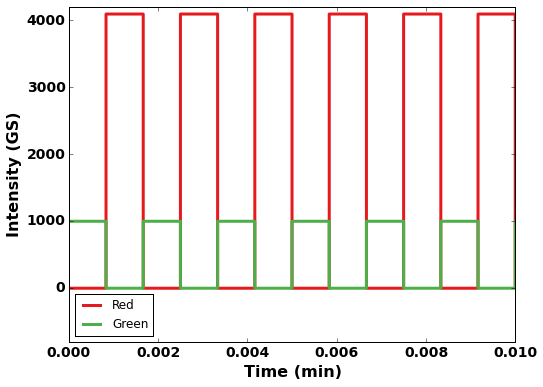

In [12]:
## Plot the 100ms period (well "0")
wellIndices = [0] # Just the first well
wellIndices = lpfp.trueIndex(wellIndices, rm) # derandomize
mplargs={'xlim': (0,0.01),
         'chLabels': ['Red', 'Green'],
         'ylim': (-800,4200)}
lpfp.plotLPFData(lpfdata['data'], wellIndices=wellIndices, mplargs=mplargs)

### Plot the 100ms Well

Green control well is correct, indicating all randomization and de-randomization is happening correctly. Furthermore, the LEDs are all off at the last time step, as expected.

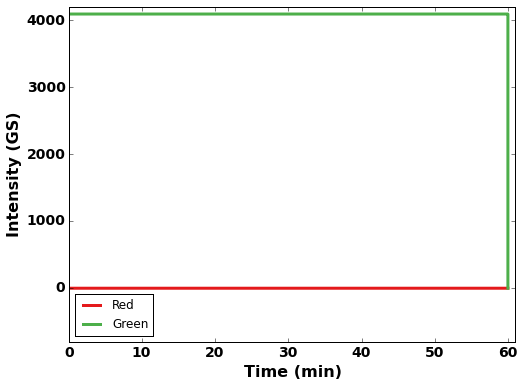

In [13]:
## Plot the Green control (well "22")
wellIndices = [22] # Just the first well
wellIndices = lpfp.trueIndex(wellIndices, rm) # derandomize
mplargs={'xlim': (0,61),
         'chLabels': ['Red', 'Green'],
         'ylim': (-800,4200)}
lpfp.plotLPFData(lpfdata['data'], wellIndices=wellIndices, mplargs=mplargs)